<a href="https://colab.research.google.com/github/cku7808/Stacked-denoising-AE/blob/main/Stacked_Denoising_AE_Random_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

%matplotlib inline

In [2]:
train_data = datasets.MNIST("dataset", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST("dataset", train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 76016234.64it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36377085.23it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 19939371.93it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18585881.72it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [3]:
print("number of train data :",len(train_data))
print("number of test data :",len(test_data))

number of train data : 60000
number of test data : 10000


In [4]:
train_data[0] # tuple 형태로 (tensor, label)로 구성

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [5]:
train_data[0][0].shape # (1,28,28)

torch.Size([1, 28, 28])

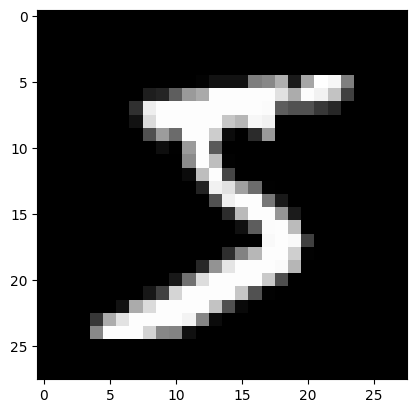

In [6]:
tmp_img, tmp_label = train_data[0]
plt.imshow(tmp_img.squeeze(), cmap="gray")

In [7]:
batch_size = 64
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

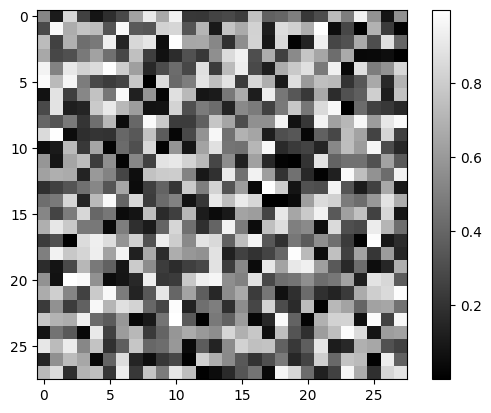

In [8]:
# 랜덤 노이즈 생성하기
noise = np.random.random((28,28))
plt.imshow(noise, cmap="gray")
plt.colorbar()

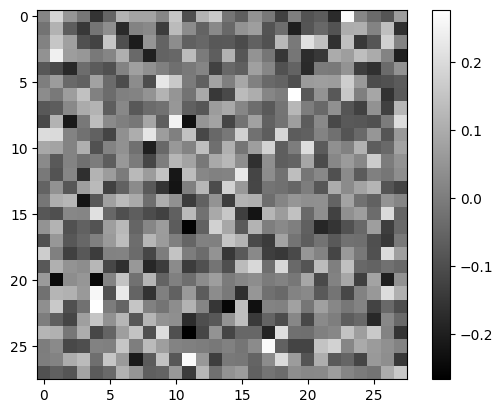

In [9]:
# 노이즈가 너무 강함 - 표준편차가 0.1인 가우시안(정규) 분포를 따르는 랜덤값 추출
noise = np.random.normal(0, 0.1, (28,28))
plt.imshow(noise, cmap="gray")
plt.colorbar()

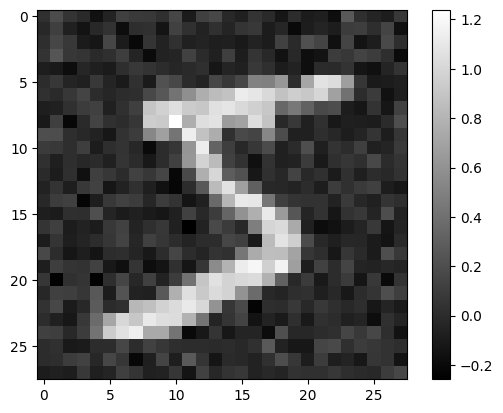

In [10]:
noise_ex = tmp_img.squeeze() + noise
plt.imshow(noise_ex, cmap="gray")
plt.colorbar()

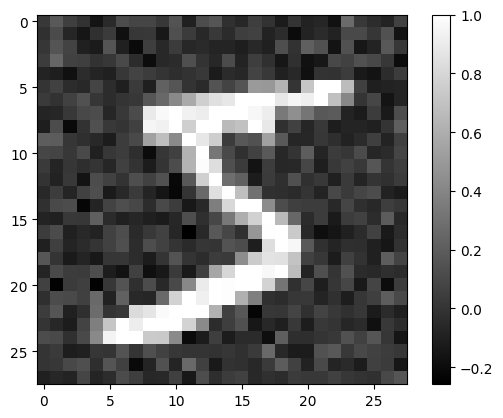

In [11]:
noise_ex[noise_ex > 1.0] = 1.0 # 1을 초과하는 경우 값을 1로 변경
plt.imshow(noise_ex, cmap="gray")
plt.colorbar()

In [12]:
# Stacked Denoising AE
class StackedDenoisingAE(nn.Module):
    def __init__(self, input_size, output_size):
        super(StackedDenoisingAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(input_size, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, output_size, kernel_size=3, stride=1, padding=0),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(output_size, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=0, output_padding=0),
            nn.Sigmoid() # 각 픽셀을 0-1 값으로 변환해야함 (grayscale이므로)
        )

    def forward(self, x):
        en_out_x = self.encoder(x)
        de_out_x = self.decoder(en_out_x)
        return de_out_x

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sdae_model = StackedDenoisingAE(1,64)
sdae_model = sdae_model.to(device)

In [14]:
criterion = nn.MSELoss()
# optimizer = optim.Adam(sdae_model.parameters(), lr=0.00001)
optimizer = optim.SGD(sdae_model.parameters(), lr=0.00001)
device = "cuda" if torch.cuda.is_available() else "cpu"

epochs = 100
train_loss = []
for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss = 0

    for data in tqdm(train_loader, total=len(train_loader)):
        x, _ = data
        x = x.to(torch.float).to(device)
        noise = torch.randn_like(x) * 0.1  # x의 형상을 하는 평균0, 표준편차1인 정규분포에 0.1을 곱해 표준편차를 0.1로 만들기
        noise = noise.to(torch.float).to(device)
        noised_x = x + noise
        noised_x = torch.clamp(noised_x, 0, 1).to(torch.float).to(device)  # [0, 1] 범위로 클리핑 및 GPU로 올리기

        out_x = sdae_model(noised_x)
        loss = criterion(out_x, x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss.append(total_loss/len(train_loader))

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


100%|██████████| 938/938 [00:17<00:00, 53.24it/s]


Epoch 1/100, Loss: 0.1088


100%|██████████| 938/938 [00:08<00:00, 104.88it/s]


Epoch 2/100, Loss: 0.0937


100%|██████████| 938/938 [00:09<00:00, 96.23it/s] 


Epoch 3/100, Loss: 0.0863


100%|██████████| 938/938 [00:09<00:00, 96.61it/s] 


Epoch 4/100, Loss: 0.0754


100%|██████████| 938/938 [00:08<00:00, 106.23it/s]


Epoch 5/100, Loss: 0.0469


100%|██████████| 938/938 [00:09<00:00, 95.74it/s] 


Epoch 6/100, Loss: 0.0266


100%|██████████| 938/938 [00:11<00:00, 83.25it/s] 


Epoch 7/100, Loss: 0.0193


100%|██████████| 938/938 [00:09<00:00, 96.54it/s]


Epoch 8/100, Loss: 0.0160


100%|██████████| 938/938 [00:08<00:00, 104.28it/s]


Epoch 9/100, Loss: 0.0125


100%|██████████| 938/938 [00:09<00:00, 97.06it/s] 


Epoch 10/100, Loss: 0.0106


100%|██████████| 938/938 [00:09<00:00, 95.73it/s] 


Epoch 11/100, Loss: 0.0091


100%|██████████| 938/938 [00:08<00:00, 106.42it/s]


Epoch 12/100, Loss: 0.0084


100%|██████████| 938/938 [00:09<00:00, 95.72it/s] 


Epoch 13/100, Loss: 0.0082


100%|██████████| 938/938 [00:09<00:00, 95.17it/s] 


Epoch 14/100, Loss: 0.0071


100%|██████████| 938/938 [00:09<00:00, 97.66it/s]


Epoch 15/100, Loss: 0.0068


100%|██████████| 938/938 [00:09<00:00, 99.84it/s] 


Epoch 16/100, Loss: 0.0060


100%|██████████| 938/938 [00:09<00:00, 96.18it/s] 


Epoch 17/100, Loss: 0.0062


100%|██████████| 938/938 [00:09<00:00, 95.41it/s]


Epoch 18/100, Loss: 0.0061


100%|██████████| 938/938 [00:08<00:00, 105.93it/s]


Epoch 19/100, Loss: 0.0066


100%|██████████| 938/938 [00:09<00:00, 95.78it/s] 


Epoch 20/100, Loss: 0.0062


100%|██████████| 938/938 [00:10<00:00, 93.76it/s] 


Epoch 21/100, Loss: 0.0056


100%|██████████| 938/938 [00:09<00:00, 101.16it/s]


Epoch 22/100, Loss: 0.0052


100%|██████████| 938/938 [00:09<00:00, 96.62it/s] 


Epoch 23/100, Loss: 0.0054


100%|██████████| 938/938 [00:09<00:00, 94.17it/s] 


Epoch 24/100, Loss: 0.0052


100%|██████████| 938/938 [00:09<00:00, 94.27it/s]


Epoch 25/100, Loss: 0.0049


100%|██████████| 938/938 [00:09<00:00, 104.00it/s]


Epoch 26/100, Loss: 0.0042


100%|██████████| 938/938 [00:09<00:00, 94.27it/s] 


Epoch 27/100, Loss: 0.0051


100%|██████████| 938/938 [00:10<00:00, 93.71it/s] 


Epoch 28/100, Loss: 0.0048


100%|██████████| 938/938 [00:09<00:00, 98.18it/s]


Epoch 29/100, Loss: 0.0044


100%|██████████| 938/938 [00:09<00:00, 96.61it/s] 


Epoch 30/100, Loss: 0.0040


100%|██████████| 938/938 [00:10<00:00, 93.60it/s] 


Epoch 31/100, Loss: 0.0042


100%|██████████| 938/938 [00:10<00:00, 92.37it/s]


Epoch 32/100, Loss: 0.0046


100%|██████████| 938/938 [00:09<00:00, 102.54it/s]


Epoch 33/100, Loss: 0.0044


100%|██████████| 938/938 [00:09<00:00, 94.64it/s] 


Epoch 34/100, Loss: 0.0041


100%|██████████| 938/938 [00:10<00:00, 93.63it/s] 


Epoch 35/100, Loss: 0.0040


100%|██████████| 938/938 [00:09<00:00, 98.71it/s]


Epoch 36/100, Loss: 0.0041


100%|██████████| 938/938 [00:09<00:00, 96.78it/s] 


Epoch 37/100, Loss: 0.0039


100%|██████████| 938/938 [00:09<00:00, 93.81it/s] 


Epoch 38/100, Loss: 0.0042


100%|██████████| 938/938 [00:09<00:00, 94.36it/s]


Epoch 39/100, Loss: 0.0041


100%|██████████| 938/938 [00:09<00:00, 103.70it/s]


Epoch 40/100, Loss: 0.0037


100%|██████████| 938/938 [00:09<00:00, 93.87it/s] 


Epoch 41/100, Loss: 0.0038


100%|██████████| 938/938 [00:10<00:00, 93.36it/s] 


Epoch 42/100, Loss: 0.0034


100%|██████████| 938/938 [00:09<00:00, 98.34it/s]


Epoch 43/100, Loss: 0.0036


100%|██████████| 938/938 [00:09<00:00, 98.50it/s] 


Epoch 44/100, Loss: 0.0038


100%|██████████| 938/938 [00:10<00:00, 93.29it/s] 


Epoch 45/100, Loss: 0.0032


100%|██████████| 938/938 [00:09<00:00, 94.17it/s]


Epoch 46/100, Loss: 0.0034


100%|██████████| 938/938 [00:09<00:00, 102.24it/s]


Epoch 47/100, Loss: 0.0033


100%|██████████| 938/938 [00:10<00:00, 93.10it/s] 


Epoch 48/100, Loss: 0.0037


100%|██████████| 938/938 [00:10<00:00, 93.11it/s] 


Epoch 49/100, Loss: 0.0033


100%|██████████| 938/938 [00:09<00:00, 98.00it/s]


Epoch 50/100, Loss: 0.0036


100%|██████████| 938/938 [00:09<00:00, 99.36it/s] 


Epoch 51/100, Loss: 0.0033


100%|██████████| 938/938 [00:09<00:00, 94.96it/s] 


Epoch 52/100, Loss: 0.0032


100%|██████████| 938/938 [00:09<00:00, 94.63it/s]


Epoch 53/100, Loss: 0.0034


100%|██████████| 938/938 [00:09<00:00, 103.51it/s]


Epoch 54/100, Loss: 0.0031


100%|██████████| 938/938 [00:09<00:00, 94.60it/s] 


Epoch 55/100, Loss: 0.0031


100%|██████████| 938/938 [00:09<00:00, 93.85it/s] 


Epoch 56/100, Loss: 0.0032


100%|██████████| 938/938 [00:09<00:00, 97.98it/s]


Epoch 57/100, Loss: 0.0028


100%|██████████| 938/938 [00:09<00:00, 99.26it/s]


Epoch 58/100, Loss: 0.0031


100%|██████████| 938/938 [00:09<00:00, 94.79it/s] 


Epoch 59/100, Loss: 0.0028


100%|██████████| 938/938 [00:09<00:00, 94.30it/s]


Epoch 60/100, Loss: 0.0028


100%|██████████| 938/938 [00:09<00:00, 103.57it/s]


Epoch 61/100, Loss: 0.0031


100%|██████████| 938/938 [00:10<00:00, 93.62it/s]


Epoch 62/100, Loss: 0.0032


100%|██████████| 938/938 [00:09<00:00, 94.36it/s] 


Epoch 63/100, Loss: 0.0028


100%|██████████| 938/938 [00:09<00:00, 100.74it/s]


Epoch 64/100, Loss: 0.0024


100%|██████████| 938/938 [00:09<00:00, 99.20it/s] 


Epoch 65/100, Loss: 0.0026


100%|██████████| 938/938 [00:09<00:00, 96.12it/s] 


Epoch 66/100, Loss: 0.0027


100%|██████████| 938/938 [00:09<00:00, 95.39it/s]


Epoch 67/100, Loss: 0.0027


100%|██████████| 938/938 [00:09<00:00, 104.22it/s]


Epoch 68/100, Loss: 0.0027


100%|██████████| 938/938 [00:09<00:00, 95.69it/s] 


Epoch 69/100, Loss: 0.0026


100%|██████████| 938/938 [00:09<00:00, 95.17it/s] 


Epoch 70/100, Loss: 0.0026


100%|██████████| 938/938 [00:09<00:00, 101.94it/s]


Epoch 71/100, Loss: 0.0027


100%|██████████| 938/938 [00:09<00:00, 97.65it/s] 


Epoch 72/100, Loss: 0.0031


100%|██████████| 938/938 [00:09<00:00, 95.07it/s] 


Epoch 73/100, Loss: 0.0023


100%|██████████| 938/938 [00:09<00:00, 95.99it/s]


Epoch 74/100, Loss: 0.0024


100%|██████████| 938/938 [00:09<00:00, 103.53it/s]


Epoch 75/100, Loss: 0.0023


100%|██████████| 938/938 [00:09<00:00, 95.06it/s] 


Epoch 76/100, Loss: 0.0022


100%|██████████| 938/938 [00:09<00:00, 94.48it/s] 


Epoch 77/100, Loss: 0.0023


100%|██████████| 938/938 [00:08<00:00, 105.08it/s]


Epoch 78/100, Loss: 0.0026


100%|██████████| 938/938 [00:09<00:00, 94.57it/s] 


Epoch 79/100, Loss: 0.0028


100%|██████████| 938/938 [00:09<00:00, 94.79it/s] 


Epoch 80/100, Loss: 0.0023


100%|██████████| 938/938 [00:09<00:00, 97.96it/s]


Epoch 81/100, Loss: 0.0023


100%|██████████| 938/938 [00:09<00:00, 101.09it/s]


Epoch 82/100, Loss: 0.0025


100%|██████████| 938/938 [00:09<00:00, 95.90it/s] 


Epoch 83/100, Loss: 0.0024


100%|██████████| 938/938 [00:09<00:00, 94.99it/s]


Epoch 84/100, Loss: 0.0023


100%|██████████| 938/938 [00:08<00:00, 105.56it/s]


Epoch 85/100, Loss: 0.0026


100%|██████████| 938/938 [00:09<00:00, 94.75it/s] 


Epoch 86/100, Loss: 0.0023


100%|██████████| 938/938 [00:09<00:00, 94.69it/s] 


Epoch 87/100, Loss: 0.0022


100%|██████████| 938/938 [00:09<00:00, 98.15it/s]


Epoch 88/100, Loss: 0.0028


100%|██████████| 938/938 [00:09<00:00, 99.06it/s] 


Epoch 89/100, Loss: 0.0024


100%|██████████| 938/938 [00:09<00:00, 94.70it/s] 


Epoch 90/100, Loss: 0.0024


100%|██████████| 938/938 [00:10<00:00, 90.32it/s]


Epoch 91/100, Loss: 0.0024


100%|██████████| 938/938 [00:09<00:00, 100.26it/s]


Epoch 92/100, Loss: 0.0023


100%|██████████| 938/938 [00:10<00:00, 90.26it/s] 


Epoch 93/100, Loss: 0.0029


100%|██████████| 938/938 [00:10<00:00, 91.17it/s]


Epoch 94/100, Loss: 0.0020


100%|██████████| 938/938 [00:09<00:00, 95.16it/s]


Epoch 95/100, Loss: 0.0027


100%|██████████| 938/938 [00:09<00:00, 99.34it/s] 


Epoch 96/100, Loss: 0.0024


100%|██████████| 938/938 [00:09<00:00, 95.14it/s] 


Epoch 97/100, Loss: 0.0021


100%|██████████| 938/938 [00:09<00:00, 94.01it/s] 


Epoch 98/100, Loss: 0.0022


100%|██████████| 938/938 [00:09<00:00, 101.81it/s]


Epoch 99/100, Loss: 0.0024


100%|██████████| 938/938 [00:09<00:00, 94.32it/s] 

Epoch 100/100, Loss: 0.0022


Text(0, 0.5, 'Loss')

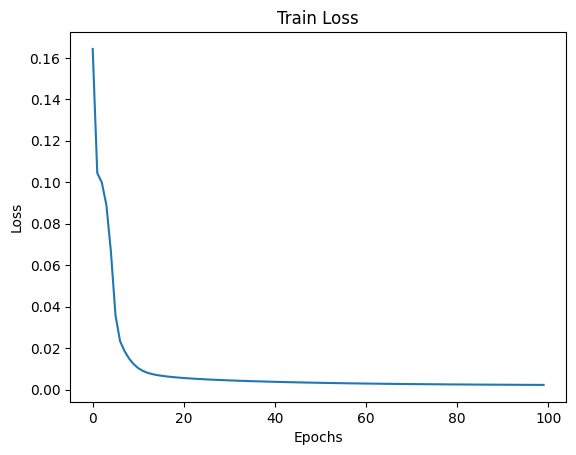

In [15]:
# train loss graph
plt.title("Train Loss")
plt.plot(train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')


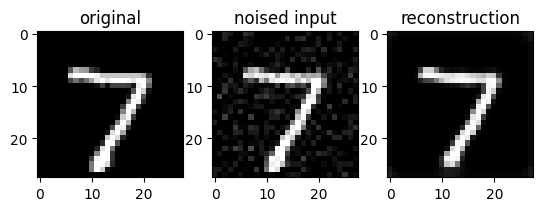

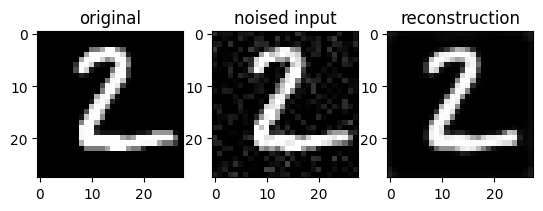

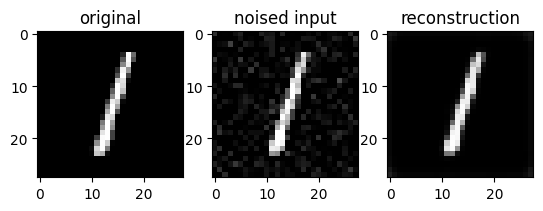

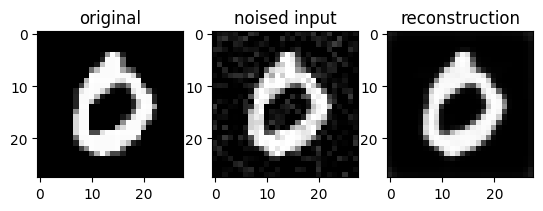

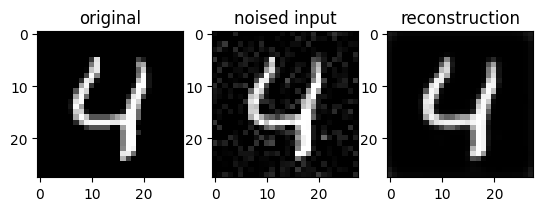

In [16]:
# test
sdae_model.eval()
for i, data in enumerate(test_loader):
    if i < 5:
        x, _ = data
        x = x.to(device)  # GPU로 이동

        noise = torch.randn_like(x) * 0.1  # x의 형상을 하는 평균0, 표준편차1인 정규분포에 0.1을 곱해 표준편차를 0.1로 만들기
        noise = noise.to(torch.float).to(device)
        noised_x = x + noise
        noised_x = torch.clamp(noised_x, 0, 1).to(torch.float).to(device)

        out_x = sdae_model(noised_x).cpu().detach()  # 모델 결과를 CPU로 옮기기

        fig = plt.figure()
        rows = 1
        cols = 3
        ax1 = fig.add_subplot(rows, cols, 1)
        ax1.imshow(x.cpu().numpy().squeeze(), cmap="gray")  # 이미지를 CPU로 옮기기
        ax1.set_title("original")

        ax2 = fig.add_subplot(rows, cols, 2)
        ax2.imshow(noised_x.cpu().numpy().squeeze(), cmap="gray")  # 이미지를 CPU로 옮기기
        ax2.set_title("noised input")

        ax3 = fig.add_subplot(rows, cols, 3)
        ax3.imshow(out_x.numpy().squeeze(), cmap="gray")  # 이미지를 CPU로 옮기기
        ax3.set_title("reconstruction")

        plt.show()
